In [1]:
#made up database of infomation for people
                #Phone,   Location,     Friends, Name
target_info = [['345544', 'Disney Land', '6','Ariel Sharon'], 
               ['444232', 'USA', '3', 'Colin Powell'], 
               ['345322', 'London', '5', 'Donald Rumsfeld'],
               ['765434567', 'GERMANY', '5','George W Bush'],
               ['5654323456', 'SCOTLAND', '1','Gerhard Schroeder'],
               ['86434654', 'BRAZIL', '1','Hugo Chavez'],
               ['765434567', 'ICELAND', '7','Tony Blair'],
              ['765434567', 'ICELAND', '7','Tony Blair'],
              ['765434567', 'ICELAND', '7','Tony Blair'],
              ['765434567', 'ICELAND', '7','Tony Blair'],
              ['765434567', 'ICELAND', '7','Serena Williams'],
              ['765434567', 'ICELAND', '7','Tony Blair']]

In [2]:
from __future__ import print_function

from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

In [15]:
#This function fetches data from the LFW database. 
#It returns the X (Images), Y (Name Labels), h and w (Res), and number of classes (People in dataset)
def fetch_data():
    
    #Fetch image data from the database. Resize to 0.4 and only accept people with more than 70 face images.
    lfw_people = fetch_lfw_people(min_faces_per_person=50, resize=0.4)

    # introspect the images arrays to find the shapes (for plotting)
    #Find how many samples we have (How many images, along with height and width)
    n_samples, h, w = lfw_people.images.shape

    # for machine learning we use the 2 data directly (as relative pixel
    # positions info is ignored by this model)
    #Find features No.
    X = lfw_people.data
    n_features = X.shape[1]

    # the label to predict is the id of the person
    y = lfw_people.target
    #Target names contains the list of people within the dataset
    target_names = lfw_people.target_names
    #No. of classes = Number of people.
    n_classes = target_names.shape[0]
    
    print("Total dataset size:")
    print(" n_samples: %d" % n_samples)
    print(" Height: %d" % h)
    print(" Width: %d" % w)
    #No of features is just the pixel height x width
    print(" n_features: %d" % n_features)
    #Class is the No. of People in the dataset
    print(" n_classes: %d\n" % n_classes)
    
    return X, y, target_names, n_classes, h, w

In [16]:
#This function splits the data into 25% Test and 75% Train
def split_data(X, y):
    
    X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)
    
    return X_train, X_test, y_train, y_test

In [17]:
#This function creates eigenfaces from the dataset, and transforms current X test and train data into PCA dimension
def pca_eigenfaces(n_components, X_train, X_test, h, w):
    
    # Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
    # dataset): unsupervised feature extraction / dimensionality reduction

    print("Extracting the top %d eigenfaces from %d faces"
          % (n_components, X_train.shape[0]))
    t0 = time()

    #Extract the top 100 eigenfaces
    pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train)
    print("done in %0.3fs" % (time() - t0))

    #Reshape
    eigenfaces = pca.components_.reshape((n_components, h, w))
    
    
    print("Projecting the input data on the eigenfaces orthonormal basis")
    t0 = time()
    #Each image will now have 100 weights once transformed. (Much Smaller data to deal with)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    print("done in %0.3fs\n" % (time() - t0))
    
    return X_train_pca, X_test_pca, eigenfaces

In [18]:
# Train a SVM classification model
def train_model(X_train_pca, y_train):
    print("Fitting the classifier to the training set")
    t0 = time()
    param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
                  'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
    #Train the model
    clf = clf.fit(X_train_pca, y_train)
    print("done in %0.3fs" % (time() - t0))
    print("Best estimator found by grid search:")
    print(clf.best_estimator_)
    print("\n")

    return clf

In [19]:
# Quantitative evaluation of the model quality on the test set
def predict_single(y_pred, y_test, target_names, target_info, predict_no, images, h,w):
    
    print("\nSingle Predict Info")
    print("Test " + " : "+ target_names[y_test[predict_no]] + " Prediction: " + target_names[y_pred[predict_no]])
    print("Name : " + target_info[y_pred[predict_no]][3])
    print("Phone No. : " + target_info[y_pred[predict_no]][0])
    print("Location : " + target_info[y_pred[predict_no]][1])
    print("Friends : " + target_info[y_pred[predict_no]][2])
    
    plt.figure(figsize=(1.8, 2.4))
    plt.imshow(images[predict_no].reshape((h, w)), cmap=plt.cm.gray)
    plt.xticks(())
    plt.yticks(())

In [20]:
# Quantitative evaluation of the model quality on the test set
def predict_people(clf, target_names, X_test_pca, y_test, n_classes):
    print("Predicting people from test data")
    t0 = time()
    #Predict the test set
    y_pred = clf.predict(X_test_pca)
    print("done in %0.3fs" % (time() - t0))
    
    print("Classification Report")
    print(classification_report(y_test, y_pred, target_names=target_names))
    print("Confusion Matrix")
    print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))
    print("Test Results")
    for x in range(y_test.shape[0]):
        print("Test " + str(x) + " : "+ target_names[y_test[x]] + " Prediction: " + target_names[y_pred[x]])
   
        
    return y_pred

In [21]:
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    #plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

In [22]:
# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

Total dataset size:
 n_samples: 1560
 Height: 50
 Width: 37
 n_features: 1850
 n_classes: 12

Extracting the top 100 eigenfaces from 1170 faces
done in 0.253s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.031s

Fitting the classifier to the training set
done in 32.384s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


Predicting people from test data
done in 0.071s
Classification Report
                   precision    recall  f1-score   support

     Ariel Sharon       0.70      0.88      0.78        16
     Colin Powell       0.85      0.91      0.88        66
  Donald Rumsfeld       0.66      0.78      0.71        27
    George W Bush       0.92      0.89      0.90       140
Gerhard Schroeder       0.91      0.88      0.89        24
      H

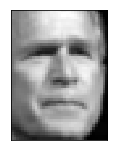

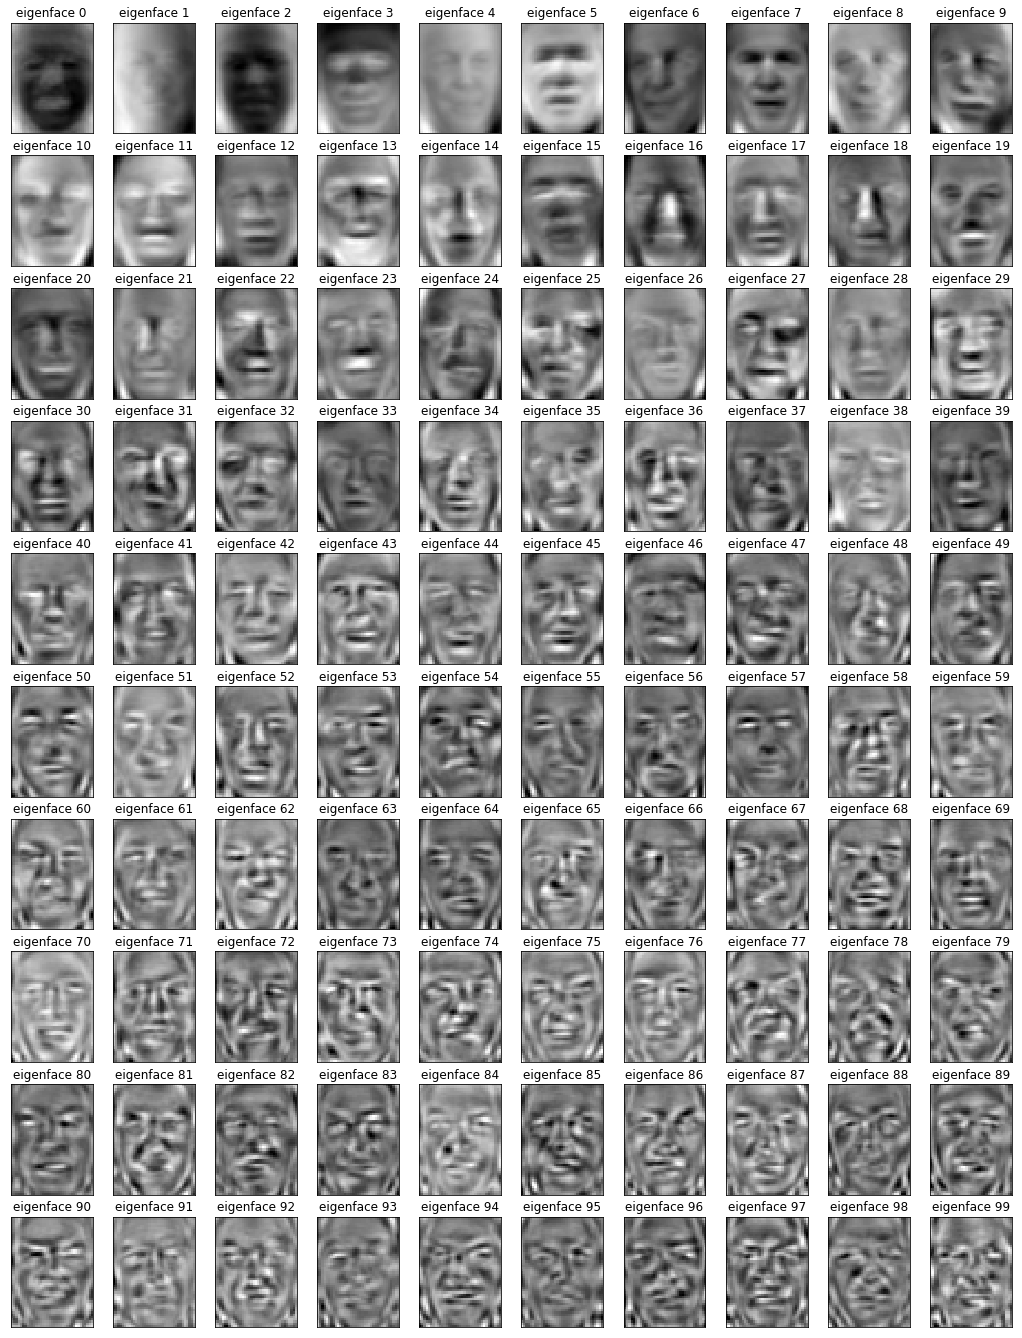

In [23]:
#-- MAIN METHOD -- #

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

#Only Keep the the top 100 Eigenfaces
n_components = 100


#Fetch image data from the database
X, y, target_names, n_classes, h, w = fetch_data()

#Split Data into Test and Train
X_train, X_test, y_train, y_test = split_data(X,y)

#Run PCA algorithm to create eigenfaces
X_train_pca, X_test_pca, eigenfaces = pca_eigenfaces(n_components, X_train, X_test, h, w)

#Train the model
clf = train_model(X_train_pca, y_train)

#Make Predictions
y_pred = predict_people(clf, target_names, X_test_pca, y_test, n_classes)

#Make a single Prediction and return person info
#In current setting, this will test and predict George Bush and return made up info
predict_no = 0
predict_single(y_pred, y_test, target_names, target_info, predict_no, X_test, h,w)


# plot the gallery of the most significative eigenfaces
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w, 10, 10)

plt.show()


Single Predict Info
Test  : Serena Williams Prediction: Serena Williams
Name : Serena Williams
Phone No. : 765434567
Location : ICELAND
Friends : 7


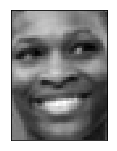

In [25]:
predict_single(y_pred, y_test, target_names, target_info, 38,X_test, h,w)

In [13]:
target_names


array(['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush',
       'Gerhard Schroeder', 'Hugo Chavez', 'Tony Blair'], dtype='<U17')